In [1]:
# enable automatic reloading of the notebook
%load_ext autoreload
%autoreload 2

# Tutorial: creating and comparing graph and timeseries embeddings
The following notebook provides a demonstration how to create and compare embeddings from a timeseries and graphs created from this timeseries with different methods.

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from core.model import Timeseries, TimeseriesPreprocessing, TimeseriesPreprocessingSegmentation, TimeseriesPreprocessingSlidingWindow, TimeseriesPreprocessingComposite, TimeseriesView, TimeGraph, ToSequenceVisitorSlidingWindow, ToSequenceVisitor, ToSequenceVisitorOrdinalPartition
from tsg_io.input import CsvFile, TsFile
from from_graph.strategy_to_time_sequence import StrategyNextValueInNodeRandom, StrategyNextValueInNodeRandomForSlidingWindow, StrategyNextValueInNodeRoundRobin, StrategyNextValueInNodeRoundRobinForSlidingWindow, StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs, StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph, StrategySelectNextNodeRandomly, StrategySelectNextNodeRandomDegree, StrategySelectNextNodeRandomWithRestart, StrategyNextValueInNodeOrdinalPartition
from to_graph.strategy_linking_graph import StrategyLinkingGraphByValueWithinRange, LinkNodesWithinGraph
from to_graph.strategy_linking_multi_graphs import LinkGraphs
from to_graph.strategy_to_graph import BuildTimeseriesToGraphNaturalVisibilityStrategy, BuildTimeseriesToGraphHorizontalVisibilityStrategy, BuildTimeseriesToGraphOrdinalPartition, BuildTimeseriesToGraphQuantile
from embeddings.ts2g2_embeddings import EmbeddingRanking, VisitorGraphEmbeddingModelDoc2Vec, VisitorTimeseriesEmbeddingModelTS2Vec
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Accessing data
We first get path to the data.

In [3]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()

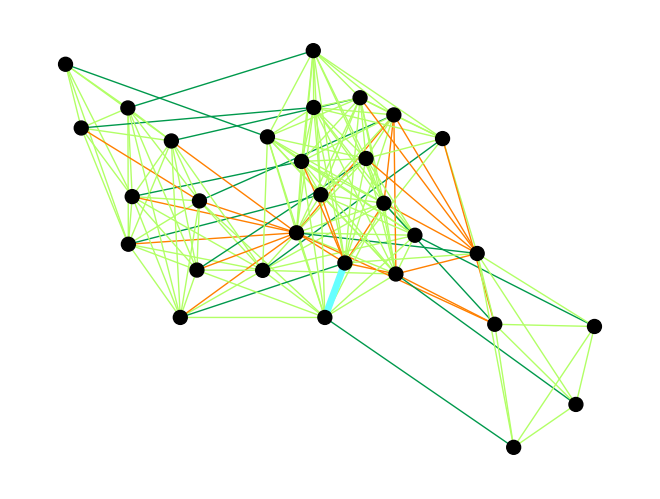

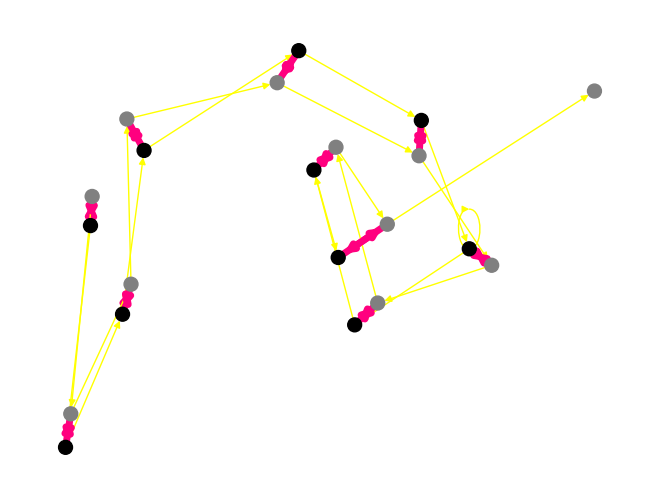

In [4]:
timegraph_natural_visibility = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 90))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(LinkNodesWithinGraph().by_value(StrategyLinkingGraphByValueWithinRange(2)).seasonalities(15))\
    .draw()

timegraph_ordinal_partition = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 120))\
    .add(Timeseries(CsvFile(apple_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(120, 180)))\
    .to_histogram(15)\
    .to_graph(BuildTimeseriesToGraphOrdinalPartition(10, 5).get_strategy())\
    .link(LinkGraphs().time_cooccurrence())\
    .draw()

Then we set parameters and train models for creating embeddings.

In [5]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()
embedding_size = 20

# to train graph embedding model, we need to provide multiple graphs. We chose arbitrary two as an example.
model_graph = VisitorGraphEmbeddingModelDoc2Vec().train_model([timegraph_natural_visibility, timegraph_ordinal_partition], embedding_size)
model_ts = VisitorTimeseriesEmbeddingModelTS2Vec().train_model(path, embedding_size, epoch=20)

# VisitorTimeseriesEmbeddingModelTS2Vec model was made with the help of TS2Vec library (available on: https://github.com/zhihanyue/ts2vec.git; version: b0088e14a99706c05451316dc6db8d3da9351163)



Epoch #0: loss=2.157383441925049
Epoch #1: loss=1.5637575387954712
Epoch #2: loss=1.766700267791748
Epoch #3: loss=1.7162991762161255
Epoch #4: loss=2.081728458404541
Epoch #5: loss=1.465295433998108
Epoch #6: loss=2.100123882293701
Epoch #7: loss=2.0829761028289795
Epoch #8: loss=1.8936793804168701
Epoch #9: loss=1.871886968612671
Epoch #10: loss=2.059738874435425
Epoch #11: loss=1.667407512664795
Epoch #12: loss=1.8802294731140137
Epoch #13: loss=1.8239470720291138
Epoch #14: loss=1.7728564739227295
Epoch #15: loss=1.8554028272628784
Epoch #16: loss=1.7092828750610352
Epoch #17: loss=1.7523998022079468
Epoch #18: loss=1.1741472482681274
Epoch #19: loss=1.9522279500961304


# Comparing embeddings
Now that we have set the parametersand trained our models, we can create and compare embeddings. Firstly, we need to create EmbeddingRanking object and give it models and strategies for timeseries to graph conversion, we want to compare. Then we add as many of the timeseries segments as we want and rank them. Because graph embeddings are created using random walk, we repeat this process multiple times and then calculate the average score.

In [6]:
data = {'run':[], 'natural_visibility':[], 'horizontal_visibility':[], 'ordinal_partition':[], 'quantile':[]}
i = 1
while i <= 5:
    x = EmbeddingRanking(embedding_size)\
        .set_embedding_models(model_ts, model_graph)\
        .set_to_graph_strategies([BuildTimeseriesToGraphNaturalVisibilityStrategy(), BuildTimeseriesToGraphHorizontalVisibilityStrategy(), BuildTimeseriesToGraphOrdinalPartition(10, 5), BuildTimeseriesToGraphQuantile(4, 1)])\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(100, 200)))\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(300, 400)))\
        .embedding_ranking()\
        .kendall_tau_correlation()
    data['run'].append(i)
    i+=1
    data['natural_visibility'].append(x[0])
    data["horizontal_visibility"].append(x[1])
    data["ordinal_partition"].append(x[2])
    data["quantile"].append(x[3])

df = pd.DataFrame.from_dict(data)
average_values = df.mean()
print(average_values)

run                      3.0
natural_visibility      -0.2
horizontal_visibility   -0.2
ordinal_partition       -0.2
quantile                -0.6
dtype: float64
